In [1]:
#Hello this the test file
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Rescaling,InputLayer, regularization
from keras.layers import Conv2D, MaxPool2D, Input
import matplotlib.pylab as plt
from tensorflow.python.client import device_lib
from keras.callbacks import CSVLogger
from keras.utils import plot_model
from keras.regularizers import l2 # ridge regression
from keras.regularizers import l1 # lasso regression
from keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras import mixed_precision
import pandas as pd
import numpy as np
import os
import sys
from layers import BilinearInterpolation
from keras.layers import RandomFlip, RandomRotation, RandomZoom
import random as python_random
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from catboost import CatBoostClassifier
import catboost as cb

c:\Users\mikae\anaconda3\envs\GPUtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

file_dir = os.path.realpath(os.path.dirname('__file__'))

In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


def convert_sample(sample):
    #alternativ use
    #image, label = sample['image'], sample['label']
    image = sample['image']
    label = sample['label']
    image = tf.image.convert_image_dtype(image, tf.float16)
    label =tf.one_hot(label, 2, dtype=tf.float16)
    return image, label

# print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# gpu_available = tf.test.is_gpu_available()

# is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)

# is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

# device_lib.list_local_devices()
# print(tf. version) 

# print("if true, GPU lives: ",tf.test.is_built_with_cuda())

# tf.config.list_physical_devices('GPU')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [4]:
ds1,ds2,ds3 = tfds.load('patch_camelyon', split=['train[:20%]', 'test[:5%]', 'validation[:5%]'],
 data_dir = file_dir,
 shuffle_files = True,
 download = False)

In [5]:
tf.keras.backend.clear_session()
train_ds = ds1.map(convert_sample).batch(256)
test_ds = ds2.map(convert_sample).batch(256)
val_ds = ds3.map(convert_sample).batch(256)
#OBS JEG HAR ÆNDRET BATCH STØRRELSEN FRA 300 TIL 200

del ds1,ds2,ds3

In [7]:
# Create basic model
input_shape = (96, 96, 3)
num_classes = 2




def make_model(input_shape, num_classes):
    #Basic architecture of the CNN model
    model = Sequential()
    model.add(InputLayer(input_shape = input_shape))
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(MaxPool2D(2,2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    #model = GlobalAveragePooling2D()(model)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = 2

    model.add(Dense(units, activation = activation))
    Dropout
    return model


learning_rate = 0.001

adam_model = make_model(input_shape = input_shape, num_classes = 1)

adam_model.compile(
    optimizer = Adam(learning_rate = learning_rate),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

SGD_model = make_model(input_shape = input_shape, num_classes = 1)

SGD_model.compile(
    optimizer= SGD(learning_rate = learning_rate),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

adamax_model = make_model(input_shape = input_shape, num_classes = 1)

adamax_model.compile(
    optimizer = Adamax(learning_rate = learning_rate), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

RMSProp_model = make_model(input_shape = input_shape, num_classes = 1)

RMSProp_model.compile(
    optimizer = RMSprop(learning_rate = learning_rate),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])    

In [8]:
# Create dataframe for storing results

df_all_acc = pd.DataFrame()

In [9]:
# Adam optimizer
tf.keras.backend.clear_session()

history_adam = adam_model.fit(train_ds, epochs=30, validation_data=val_ds)
tf.keras.models.save_model(adam_model, file_dir+'\\Vanilla_Adam_CONV',save_format='tf',
include_optimizer=True)

df_all_acc['adam_accuracy'] = history_adam.history['accuracy']
df_all_acc['adam_val_accuracy'] = history_adam.history['val_accuracy']
df_all_acc['adam_loss'] = history_adam.history['loss']
df_all_acc['adam_val_loss'] = history_adam.history['val_loss']

del adam_model, history_adam


Epoch 1/30
205/205 [==============================] - 26s 80ms/step - loss: 0.5239 - accuracy: 0.7458 - val_loss: 0.4784 - val_accuracy: 0.7595
Epoch 2/30
205/205 [==============================] - 15s 73ms/step - loss: 0.4595 - accuracy: 0.7885 - val_loss: 0.4286 - val_accuracy: 0.7863
Epoch 3/30
205/205 [==============================] - 16s 75ms/step - loss: 0.4382 - accuracy: 0.8021 - val_loss: 0.4221 - val_accuracy: 0.8053
Epoch 4/30
205/205 [==============================] - 15s 73ms/step - loss: 0.4176 - accuracy: 0.8121 - val_loss: 0.4750 - val_accuracy: 0.7454
Epoch 5/30
205/205 [==============================] - 15s 73ms/step - loss: 0.3849 - accuracy: 0.8313 - val_loss: 0.3905 - val_accuracy: 0.8181
Epoch 6/30
205/205 [==============================] - 15s 74ms/step - loss: 0.3530 - accuracy: 0.8471 - val_loss: 0.4598 - val_accuracy: 0.7851
Epoch 7/30
205/205 [==============================] - 15s 73ms/step - loss: 0.3286 - accuracy: 0.8596 - val_loss: 0.3947 - val_accuracy:

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_Adam_CONV\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_Adam_CONV\assets


In [10]:
# sigmoid optimizer
tf.keras.backend.clear_session()
history_SGD = SGD_model.fit(train_ds, epochs=30, validation_data=val_ds)
tf.keras.models.save_model(SGD_model, file_dir +'\\Vanilla_SGD_CONV',save_format='tf',
include_optimizer=True)

df_all_acc['SGD_accuracy'] = history_SGD.history['accuracy']
df_all_acc['SGD_val_accuracy'] = history_SGD.history['val_accuracy']
df_all_acc['SGD_loss'] = history_SGD.history['loss']
df_all_acc['SGD_val_loss'] = history_SGD.history['val_loss']

del SGD_model, history_SGD


Epoch 1/30
205/205 [==============================] - 16s 75ms/step - loss: 0.6911 - accuracy: 0.5163 - val_loss: 0.6911 - val_accuracy: 0.4969
Epoch 2/30
205/205 [==============================] - 15s 75ms/step - loss: 0.6876 - accuracy: 0.5563 - val_loss: 0.6879 - val_accuracy: 0.4963
Epoch 3/30
205/205 [==============================] - 16s 76ms/step - loss: 0.6845 - accuracy: 0.5961 - val_loss: 0.6849 - val_accuracy: 0.4963
Epoch 4/30
205/205 [==============================] - 15s 75ms/step - loss: 0.6811 - accuracy: 0.6326 - val_loss: 0.6809 - val_accuracy: 0.5073
Epoch 5/30
205/205 [==============================] - 15s 75ms/step - loss: 0.6768 - accuracy: 0.6650 - val_loss: 0.6755 - val_accuracy: 0.5513
Epoch 6/30
205/205 [==============================] - 15s 75ms/step - loss: 0.6712 - accuracy: 0.6855 - val_loss: 0.6683 - val_accuracy: 0.6142
Epoch 7/30
205/205 [==============================] - 15s 75ms/step - loss: 0.6638 - accuracy: 0.6953 - val_loss: 0.6589 - val_accuracy:

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_SGD_CONV\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_SGD_CONV\assets


In [11]:
# adamax optimizer
tf.keras.backend.clear_session()
history_adamax = adamax_model.fit(train_ds, epochs=30, validation_data=val_ds)
tf.keras.models.save_model(adamax_model, file_dir+'\\Vanilla_adamax_CONV',save_format='tf',
include_optimizer=True)

df_all_acc['adamax_accuracy'] = history_adamax.history['accuracy']
df_all_acc['adamax_val_accuracy'] = history_adamax.history['val_accuracy']
df_all_acc['adamax_loss'] = history_adamax.history['loss']
df_all_acc['adamax_val_loss'] = history_adamax.history['val_loss']


del adamax_model, history_adamax


Epoch 1/30
205/205 [==============================] - 15s 71ms/step - loss: 0.5222 - accuracy: 0.7441 - val_loss: 0.4600 - val_accuracy: 0.7723
Epoch 2/30
205/205 [==============================] - 15s 71ms/step - loss: 0.4747 - accuracy: 0.7799 - val_loss: 0.4575 - val_accuracy: 0.7735
Epoch 3/30
205/205 [==============================] - 15s 72ms/step - loss: 0.4588 - accuracy: 0.7899 - val_loss: 0.4345 - val_accuracy: 0.8040
Epoch 4/30
205/205 [==============================] - 15s 71ms/step - loss: 0.4449 - accuracy: 0.7966 - val_loss: 0.4373 - val_accuracy: 0.7894
Epoch 5/30
205/205 [==============================] - 15s 71ms/step - loss: 0.4300 - accuracy: 0.8062 - val_loss: 0.4217 - val_accuracy: 0.8016
Epoch 6/30
205/205 [==============================] - 15s 72ms/step - loss: 0.4056 - accuracy: 0.8195 - val_loss: 0.4456 - val_accuracy: 0.7759
Epoch 7/30
205/205 [==============================] - 15s 71ms/step - loss: 0.3902 - accuracy: 0.8276 - val_loss: 0.4302 - val_accuracy:

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_adamax_CONV\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_adamax_CONV\assets


In [12]:
# RMSProp optimizer
tf.keras.backend.clear_session()
history_RMSProp = RMSProp_model.fit(train_ds, epochs=30, validation_data=val_ds)
tf.keras.models.save_model(RMSProp_model, file_dir + '\\Vanilla_RMSProp_CONV',save_format='tf',
include_optimizer=True)

df_all_acc['RMSProp_accuracy'] = history_RMSProp.history['accuracy']
df_all_acc['RMSProp_val_accuracy'] = history_RMSProp.history['val_accuracy']
df_all_acc['RMSProp_loss'] = history_RMSProp.history['loss']
df_all_acc['RMSProp_val_loss'] = history_RMSProp.history['val_loss']


del RMSProp_model, history_RMSProp


Epoch 1/30
205/205 [==============================] - 15s 71ms/step - loss: 0.8075 - accuracy: 0.6214 - val_loss: 0.4767 - val_accuracy: 0.7753
Epoch 2/30
205/205 [==============================] - 14s 69ms/step - loss: 0.5078 - accuracy: 0.7615 - val_loss: 0.4742 - val_accuracy: 0.7668
Epoch 3/30
205/205 [==============================] - 14s 69ms/step - loss: 0.4674 - accuracy: 0.7862 - val_loss: 0.4632 - val_accuracy: 0.7747
Epoch 4/30
205/205 [==============================] - 14s 69ms/step - loss: 0.4419 - accuracy: 0.7978 - val_loss: 0.4861 - val_accuracy: 0.7650
Epoch 5/30
205/205 [==============================] - 14s 71ms/step - loss: 0.4199 - accuracy: 0.8088 - val_loss: 0.4329 - val_accuracy: 0.8089
Epoch 6/30
205/205 [==============================] - 15s 71ms/step - loss: 0.3979 - accuracy: 0.8231 - val_loss: 0.4720 - val_accuracy: 0.7796
Epoch 7/30
205/205 [==============================] - 14s 70ms/step - loss: 0.3688 - accuracy: 0.8399 - val_loss: 0.4778 - val_accuracy:

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_RMSProp_CONV\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_RMSProp_CONV\assets


In [ ]:
adam_model = tf.keras.models.load_model(file_dir +'\\Vanilla_Adam_CONV')
SGD_model = tf.keras.models.load_model(file_dir +'\\Vanilla_SGD_CONV')
adamax_model = tf.keras.models.load_model(file_dir +'\\Vanilla_adamax_CONV')
RMSProp_model = tf.keras.models.load_model(file_dir +'\\Vanilla_RMSProp_CONV')


# vanilla_model = tf.keras.models.load_model(r'C:\Users\mikae\Anvendt maskinelearing eksamen\Vanilla_CONV')


models = pd.DataFrame({
    'Model': ['adam_model', 'SGD_model', 'adamax_model', 'RMSProp_model'],
    'Score': [adam_model.evaluate(val_ds), SGD_model.evaluate(val_ds), adamax_model.evaluate(val_ds), RMSProp_model.evaluate(val_ds)]})
    
print(models.sort_values(by='Score', ascending=False))#create dataframer for our models to compare their accuracy


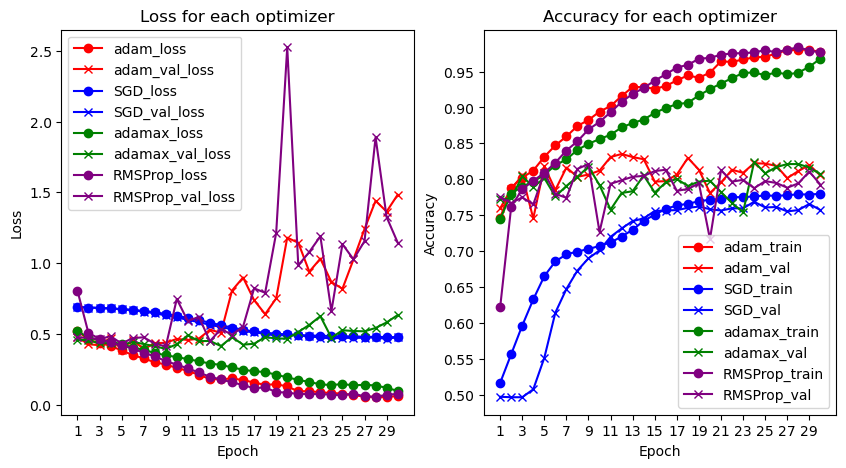

In [17]:
df_all_acc.to_csv(file_dir + '\\acc_loss_each_optimizer.csv', index = False)

# set index to 1 instead of 0 in the dataframe
# df_all_acc.index = df_all_acc.index + 1


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df_all_acc['adam_loss'], marker = 'o', color = 'red')
plt.plot(df_all_acc['adam_val_loss'], marker = 'x', color = 'red')
plt.plot(df_all_acc['SGD_loss'], marker = 'o', color = 'blue')
plt.plot(df_all_acc['SGD_val_loss'], marker = 'x', color = 'blue')
plt.plot(df_all_acc['adamax_loss'], marker = 'o', color = 'green')
plt.plot(df_all_acc['adamax_val_loss'], marker = 'x', color = 'green')
plt.plot(df_all_acc['RMSProp_loss'], marker = 'o', color = 'purple')
plt.plot(df_all_acc['RMSProp_val_loss'], marker = 'x', color = 'purple')
plt.title('Loss for each optimizer')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.xticks(np.arange(1, 30, 2))
plt.legend(['adam_loss', 'adam_val_loss', 'SGD_loss', 'SGD_val_loss', 'adamax_loss', 'adamax_val_loss', 'RMSProp_loss', 'RMSProp_val_loss'], loc='upper left')


#plot the validation accuracy and epochs for each model
plt.subplot(1, 2, 2)
plt.plot(df_all_acc['adam_accuracy'], marker = 'o', color = 'red')
plt.plot(df_all_acc['adam_val_accuracy'], marker = 'x', color = 'red')
plt.plot(df_all_acc['SGD_accuracy'], marker = 'o', color = 'blue')
plt.plot(df_all_acc['SGD_val_accuracy'], marker = 'x', color = 'blue')
plt.plot(df_all_acc['adamax_accuracy'], marker = 'o', color = 'green')
plt.plot(df_all_acc['adamax_val_accuracy'], marker = 'x', color = 'green')
plt.plot(df_all_acc['RMSProp_accuracy'], marker = 'o', color = 'purple')
plt.plot(df_all_acc['RMSProp_val_accuracy'], marker = 'x', color = 'purple')
plt.title('Accuracy for each optimizer')
plt.ylabel('Accuracy')
# tick marks for y axis
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epoch') #tick marks for each epoch (1-20)
plt.xticks(np.arange(1, 30, 2) )
plt.legend(['adam_train', 'adam_val', 'SGD_train', 'SGD_val', 'adamax_train', 'adamax_val', 'RMSProp_train', 'RMSProp_val'], loc='lower right')
plt.show()



In [6]:
#base model with best optimizer with regularization and dropout


tf.keras.backend.clear_session()
input_shape = (96, 96, 3)

def regulazid_adam_model(input_shape, num_classes, weight_regularizer, dropout_value):
    #Basic architecture of the CNN model
    model = Sequential()
    model.add(InputLayer(input_shape = input_shape))
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))
    #layer two
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))


    #layer three
    model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))

    #layer four
    model.add(Flatten())
    model.add(Dropout(dropout_value))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    #model = GlobalAveragePooling2D()(model)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = 2

    model.add(Dense(units, activation = activation, kernel_regularizer = weight_regularizer))
    model.compile(
        optimizer= Adam(learning_rate=0.001),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    return model


df_all_acc = pd.DataFrame()


In [7]:
tf.keras.backend.clear_session()
regu_l2_model = regulazid_adam_model(input_shape = input_shape, num_classes = 1,
 weight_regularizer = l2(0.01), dropout_value = 0.2)

history_regu_l2 = regu_l2_model.fit(train_ds, epochs=30, validation_data=val_ds)

tf.keras.models.save_model(regu_l2_model, file_dir+'\\Regu_l2_CONV',
 save_format='tf', include_optimizer=True)

df_all_acc['regu_l2_accuracy'] = history_regu_l2.history['accuracy']
df_all_acc['regu_l2_val_accuracy'] = history_regu_l2.history['val_accuracy']
df_all_acc['regu_l2_loss'] = history_regu_l2.history['loss']
df_all_acc['regu_l2_val_loss'] = history_regu_l2.history['val_loss']


del regu_l2_model, history_regu_l2


Epoch 1/30
205/205 [==============================] - 30s 119ms/step - loss: 1.0102 - accuracy: 0.7307 - val_loss: 0.8338 - val_accuracy: 0.6227
Epoch 2/30
205/205 [==============================] - 23s 112ms/step - loss: 0.4723 - accuracy: 0.8167 - val_loss: 1.1443 - val_accuracy: 0.6758
Epoch 3/30
205/205 [==============================] - 23s 113ms/step - loss: 0.4191 - accuracy: 0.8362 - val_loss: 0.4397 - val_accuracy: 0.8114
Epoch 4/30
205/205 [==============================] - 23s 114ms/step - loss: 0.3843 - accuracy: 0.8511 - val_loss: 1.2193 - val_accuracy: 0.6520
Epoch 5/30
205/205 [==============================] - 23s 114ms/step - loss: 0.3552 - accuracy: 0.8638 - val_loss: 0.9360 - val_accuracy: 0.7222
Epoch 6/30
205/205 [==============================] - 23s 113ms/step - loss: 0.3332 - accuracy: 0.8730 - val_loss: 0.3771 - val_accuracy: 0.8413
Epoch 7/30
205/205 [==============================] - 24s 115ms/step - loss: 0.3077 - accuracy: 0.8834 - val_loss: 0.4697 - val_ac

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Regu_l2_CONV\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Regu_l2_CONV\assets


In [8]:
tf.keras.backend.clear_session()
regu_l1_model = regulazid_adam_model(input_shape = input_shape, num_classes = 1,
    weight_regularizer = l1(0.01), dropout_value = 0.2)

history_regu_l1 = regu_l1_model.fit(train_ds, epochs=30, validation_data=val_ds)

tf.keras.models.save_model(regu_l1_model, file_dir+'\\Regu_l1_CONV',
    save_format='tf', include_optimizer=True)

df_all_acc['regu_l1_accuracy'] = history_regu_l1.history['accuracy']
df_all_acc['regu_l1_val_accuracy'] = history_regu_l1.history['val_accuracy']
df_all_acc['regu_l1_loss'] = history_regu_l1.history['loss']
df_all_acc['regu_l1_val_loss'] = history_regu_l1.history['val_loss']


del regu_l1_model, history_regu_l1

Epoch 1/30
205/205 [==============================] - 25s 113ms/step - loss: 0.7492 - accuracy: 0.7855 - val_loss: 4.6337 - val_accuracy: 0.5043
Epoch 2/30
205/205 [==============================] - 23s 112ms/step - loss: 0.4957 - accuracy: 0.8314 - val_loss: 0.8780 - val_accuracy: 0.7210
Epoch 3/30
205/205 [==============================] - 23s 114ms/step - loss: 0.4183 - accuracy: 0.8453 - val_loss: 0.7027 - val_accuracy: 0.7790
Epoch 4/30
205/205 [==============================] - 23s 114ms/step - loss: 0.3749 - accuracy: 0.8604 - val_loss: 1.2109 - val_accuracy: 0.6935
Epoch 5/30
205/205 [==============================] - 23s 113ms/step - loss: 0.3427 - accuracy: 0.8714 - val_loss: 1.1681 - val_accuracy: 0.6880
Epoch 6/30
205/205 [==============================] - 23s 113ms/step - loss: 0.3177 - accuracy: 0.8826 - val_loss: 1.2270 - val_accuracy: 0.6862
Epoch 7/30
205/205 [==============================] - 24s 114ms/step - loss: 0.2982 - accuracy: 0.8895 - val_loss: 0.4761 - val_ac

INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Regu_l1_CONV\assets


INFO:tensorflow:Assets written to: C:\Users\mikae\Anvendt maskinelearing eksamen\Regu_l1_CONV\assets


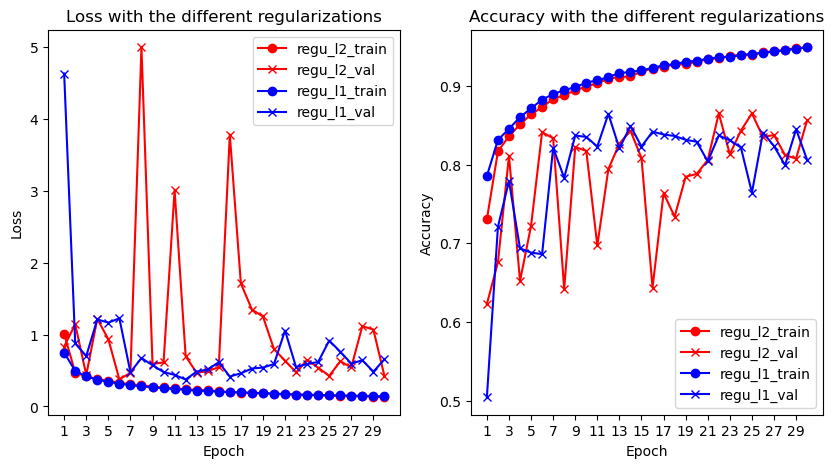

In [9]:
#save dataframe to csv
df_all_acc.to_csv(file_dir+'\\regu_l1_and_l2_model.csv', index = False)

#set the index to start at 1
df_all_acc.index = df_all_acc.index + 1

# plt plot of the accuracy and loss from the training and validation data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df_all_acc['regu_l2_loss'], marker = 'o', color = 'red')
plt.plot(df_all_acc['regu_l2_val_loss'], marker = 'x', color = 'red')
plt.plot(df_all_acc['regu_l1_loss'], marker = 'o', color = 'blue')
plt.plot(df_all_acc['regu_l1_val_loss'], marker = 'x', color = 'blue')
plt.title('Loss with the different regularizations')
plt.ylabel('Loss')
plt.xlabel('Epoch') #tick marks for each epoch (1-30)
plt.xticks(np.arange(1, 30, 2))
plt.legend(['regu_l2_train', 'regu_l2_val', 'regu_l1_train', 'regu_l1_val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(df_all_acc['regu_l2_accuracy'], marker = 'o', color = 'red')
plt.plot(df_all_acc['regu_l2_val_accuracy'], marker = 'x', color = 'red')
plt.plot(df_all_acc['regu_l1_accuracy'], marker = 'o', color = 'blue')
plt.plot(df_all_acc['regu_l1_val_accuracy'], marker = 'x', color = 'blue')
plt.title('Accuracy with the different regularizations')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') #tick marks for each epoch (1-30)
plt.xticks(np.arange(1, 30, 2))
plt.legend(['regu_l2_train', 'regu_l2_val', 'regu_l1_train', 'regu_l1_val'], loc='lower right')
plt.show()


In [1]:
tf.keras.backend.clear_session()

input_shape = (96, 96, 3)

# data_augmentation = Sequential([
#     RandomFlip("horizontal_and_vertical", input_shape=input_shape),
#     RandomRotation(0.1),    
# ])

# def data_augmentation_model(input_shape):

#     model = Sequential()
#     model.add(RandomRotation(0.2, input_shape = input_shape))
#     model.add(RandomFlip('horizontal_and_vertical'))

#     return model

def regularized_augmented_model(input_shape, num_classes, weight_regularizer, dropout_value,**data_augmentation):
    #Basic architecture of the CNN model
    model = Sequential()
    model.add(RandomFlip("horizontal_and_vertical", input_shape=input_shape))
    model.add(RandomRotation(0.1))
    # model.add(data_augmentation)
    model.add(InputLayer(input_shape = input_shape))

    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))
    #layer two
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))


    #layer three
    model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(dropout_value))

    #layer four
    model.add(Flatten())
    model.add(Dropout(dropout_value))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    #model = GlobalAveragePooling2D()(model)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = 2

    model.add(Dense(units, activation = activation, kernel_regularizer = weight_regularizer))
    model.compile(
        optimizer= Adam(learning_rate=0.001),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    return model

regularized_augmented_model.summary()

NameError: name 'tf' is not defined

In [ ]:
#Traing the model with the augmented data and the L1 regularization

tf.keras.backend.clear_session()
regu_l1_augmented_model = regularized_augmented_model(input_shape = input_shape, num_classes = 1,
    weight_regularizer = l1(0.01), dropout_value = 0.2)

history_regu_augmented_l1 = regu_l1_augmented_model.fit(train_ds, epochs=3, validation_data=val_ds)

tf.keras.models.save_model(regu_l1_augmented_model, file_dir+'\\Regu_l1_augmented_CONV',
    save_format='tf', include_optimizer=True)

df_all_acc = pd.DataFrame()

df_all_acc['regu_l1_augmented_accuracy'] = history_regu_augmented_l1.history['accuracy']
df_all_acc['regu_l1_augmented_val_accuracy'] = history_regu_augmented_l1.history['val_accuracy']
df_all_acc['regu_l1_augmented_loss'] = history_regu_augmented_l1.history['loss']
df_all_acc['regu_l1_augmented_val_loss'] = history_regu_augmented_l1.history['val_loss']

df_all_acc.to_csv(file_dir+'\\df_all_acc_regu_l1_augmented.csv', index=False)

del regu_l1_augmented_model, history_regu_augmented_l1

In [ ]:
#Load the model and continue training
tf.keras.backend.clear_session()
regu_l1_augmented_model = tf.keras.models.load_model(file_dir+'\\Regu_l1_augmented_CONV')

history_regu_augmented_l1 = regu_l1_augmented_model.fit(train_ds, epochs=20, validation_data=val_ds)

tf.keras.models.save_model(regu_l1_augmented_model, file_dir+'\\Regu_l1_augmented_CONV',
    save_format='tf', include_optimizer=True)

df_all_acc = pd.DataFrame()

df_all_acc['regu_l1_augmented_accuracy'] = history_regu_augmented_l1.history['accuracy']
df_all_acc['regu_l1_augmented_val_accuracy'] = history_regu_augmented_l1.history['val_accuracy']
df_all_acc['regu_l1_augmented_loss'] = history_regu_augmented_l1.history['loss']
df_all_acc['regu_l1_augmented_val_loss'] = history_regu_augmented_l1.history['val_loss']

df_all_acc.to_csv(file_dir+'\\df_all_acc_regu_l1_augmented.csv', index=False)

del regu_l1_augmented_model, history_regu_augmented_l1


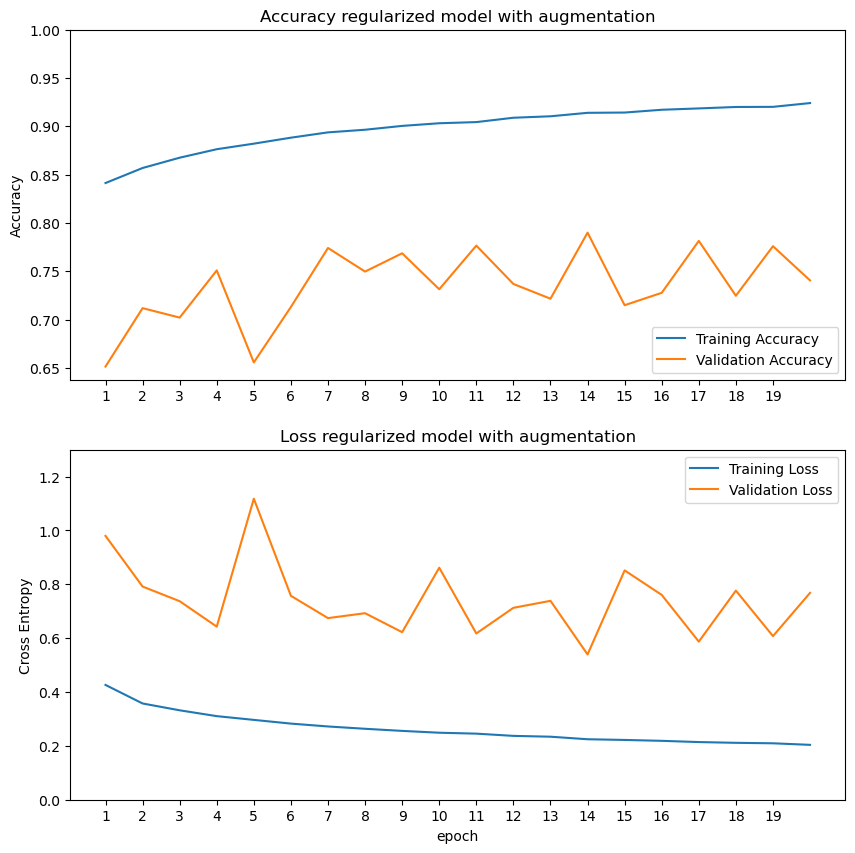

In [51]:
#load the a csv file to a dataframe
df_all_acc = pd.DataFrame()
df_all_acc = pd.read_csv(file_dir+'\\df_all_acc_regu_l1_augmented.csv')

#Setting the index of the dataframe to start from 1 instead of 0
df_all_acc.index = df_all_acc.index + 1



#Plot the validation and training accuracy and loss
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_all_acc['regu_l1_augmented_accuracy'], label='Training Accuracy')
plt.plot(df_all_acc['regu_l1_augmented_val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy regularized model with augmentation')
plt.xticks(np.arange(1,20,1))

plt.subplot(2, 1, 2)
plt.plot(df_all_acc['regu_l1_augmented_loss'], label='Training Loss')
plt.plot(df_all_acc['regu_l1_augmented_val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.3])
plt.title('Loss regularized model with augmentation')
plt.xlabel('epoch')
plt.xticks(np.arange(1,20,1))
plt.show()


In [ ]:
history_regu_base_model = regu_aug_base_model.fit(train_ds, epochs=10, validation_data=val_ds)

In [23]:
# Spatial transorner network

tf.keras.backend.clear_session()




def set_initial_weights(input_nodes: int, set_zoom: float):
    bias = np.zeros((2,3), dtype = 'float32')
    
    bias[0, 0] = set_zoom
    bias[1, 1] = set_zoom

    weights = np.zeros((input_nodes, 6), dtype = 'float32')

    return [weights, bias.flatten()]

def make_location_model(set_zoom):
    #Basic architecture of the CNN model
    location_model = Sequential()
    # location_model.add(Conv2D(6, kernel_size = 10, activation='relu', name = 'conv2d_1'))
    # location_model.add(MaxPool2D(2,2))

    location_model.add(Conv2D(8, kernel_size = 5, activation='relu', name = 'conv2d_2'))
    location_model.add(MaxPool2D(2,2))

    location_model.add(Conv2D(10, kernel_size = 3, activation='relu', name = 'conv2d_3'))
    location_model.add(MaxPool2D(2,2))

    location_model.add(Flatten(name = 'flatten_1'))
    location_model.add(Dense(32, activation='relu', name = 'dense_1'))

    location_model.add(Dense(6, activation = 'linear',
                            weights = set_initial_weights(32, set_zoom), name = 'dense_2'))
    
    return location_model


def cnn_network(sampling_shape, num_classes, weight_regularizer, dropout_value):

#Basic architecture of the CNN model
    cnn_model = Sequential()

    cnn_model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(2,2))
    cnn_model.add(Dropout(dropout_value))
    #layer two
    cnn_model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(2,2))
    cnn_model.add(Dropout(dropout_value))


    #layer three
    cnn_model.add(Conv2D(128, kernel_size = 3, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(2,2))
    cnn_model.add(Dropout(dropout_value))

    #layer four
    cnn_model.add(Flatten())
    cnn_model.add(Dropout(dropout_value))
    cnn_model.add(Dense(128, activation='relu'))


    cnn_model.add(Dense(2, activation = 'softmax', kernel_regularizer = weight_regularizer))

    return cnn_model



def spatial_transformer_network(input_shape, sampling_shape, num_classes, set_zoom):
    #Spatial transformer network
    location_model = make_location_model(set_zoom)
    cnn_net = cnn_network(sampling_shape, num_classes, l1(0.001), 0.2)
    
    image = tf.keras.layers.Input(shape = (input_shape))

    spatial_model = location_model(image)
    spatial_model = BilinearInterpolation(sampling_shape, )([image, spatial_model])
    spatial_transform = tf.keras.models.Model(inputs = image, outputs = spatial_model, name = 'spatial_transformer_network')

    stn_model = Sequential(
        [
            spatial_transform,
            cnn_net
        ]
    )

    return stn_model

#out_pre_train = tnp.asarray(stn_model.get_layer('spatial_transformer')(x_test_mod[0:1]))[0][:, :, 0]


spatial_transformer_model = spatial_transformer_network((96, 96, 3), (96, 96), 2, 0.5)



spatial_transformer_model.compile(
    optimizer = Adamax(learning_rate = 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


hist_zoom = spatial_transformer_model.fit(train_ds, epochs=5, validation_data=val_ds)       
                            #    validation_data = val_ds,
                            #    epochs = 5,
                            #    batch_size = 128,
                            #    verbose=1)


TypeError: Exception encountered when calling layer "bilinear_interpolation" (type BilinearInterpolation).

in user code:

    File "c:\Users\mikae\Anvendt maskinelearing eksamen\layers.py", line 42, in call  *
        output = self._transform(X, transformation, self.output_size)
    File "c:\Users\mikae\Anvendt maskinelearing eksamen\layers.py", line 137, in _transform  *
        sampled_grids = K.batch_dot(transformations, regular_grids)
    File "c:\Users\mikae\anaconda3\envs\GPUtf\lib\site-packages\keras\backend.py", line 2637, in batch_dot
        result = tf.matmul(x, y)

    TypeError: Input 'y' of 'BatchMatMulV2' Op has type float32 that does not match type float16 of argument 'x'.


Call arguments received by layer "bilinear_interpolation" (type BilinearInterpolation):
  • inputs=['tf.Tensor(shape=(None, 96, 96, 3), dtype=float16)', 'tf.Tensor(shape=(None, 6), dtype=float16)']
  • kwargs={'training': 'None'}